In [115]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

In [116]:
gdp_df = pd.read_csv("./data/USGDP.csv")
money_df = pd.read_csv("./data/USMoney.csv")
gdp_df.GDP = gdp_df.GDP.apply(lambda x: float(x.replace(',','')))
print("gdp:" + str(gdp_df.shape) + " money:" + str(money_df.shape)) 
money_df.tail(20)

gdp:(283, 4) money:(708, 5)


Year  Month      M1       M2  TB3MS
688  2016      5  3248.3  12761.3   0.27
689  2016      6  3248.6  12830.5   0.27
690  2016      7  3246.2  12894.9   0.30
691  2016      8  3325.5  12982.0   0.30
692  2016      9  3326.9  13038.1   0.29
693  2016     10  3335.6  13087.5   0.33
694  2016     11  3344.5  13164.7   0.45
695  2016     12  3329.2  13199.5   0.51
696  2017      1  3393.3  13278.1   0.51
697  2017      2  3370.7  13317.6   0.52
698  2017      3  3439.9  13400.4   0.74
699  2017      4  3430.3  13452.7   0.80
700  2017      5  3504.3  13517.8   0.89
701  2017      6  3496.3  13543.9   0.98
702  2017      7  3527.1  13620.4   1.07
703  2017      8  3564.6  13664.5   1.01
704  2017      9  3553.2  13703.5   1.03
705  2017     10  3594.7  13747.1   1.07
706  2017     11  3618.4  13785.5   1.23
707  2017     12  3614.6  13844.5   1.32

In [117]:
# transform months to quarters and average the data
amoney_df = money_df.groupby(money_df.index // 3, ).mean() # checked. 
amoney_df.Month = (amoney_df.index % 4) + 1
amoney_df = amoney_df.rename(columns={'Month':'Quarter'})

In [118]:
# add real GDP by adjusting GDP by GDP deflator. 
gdp_df.GDP = ((gdp_df.GDP / gdp_df.GDPDEF) * 100) #checked
gdp_cols = ['Year', 'Quarter', 'GDP', 'GDPDEF']
amoney_df = pd.merge(amoney_df, gdp_df[['Year', 'Quarter', 'GDP', 'GDPDEF']], on=['Year', 'Quarter'], how='inner') #checked. 
amoney_df = amoney_df.rename(columns={'GDP':'RGDP'})

In [119]:
# adjust for inflation using GDP deflator. 
amoney_df.M1 = (amoney_df.M1 / amoney_df.GDPDEF) * 100  # checked 
amoney_df.M2 = (amoney_df.M2 / amoney_df.GDPDEF) * 100

In [120]:
x = amoney_df.copy()
x = calculate_vif_(x)

dropping 'RGDP' at index: 5
dropping 'M2' at index: 3
Remaining variables:
Index(['Year', 'Quarter', 'M1', 'TB3MS', 'GDPDEF'], dtype='object')


In [121]:
# create an annual version of the data. 
qmoney_df = amoney_df  # quarters
ymoney_df = amoney_df.head(232).groupby(amoney_df.head(232).index // 4, ).mean()
ymoney_df.Year =  ymoney_df.Year.astype(int)
ymoney_df.shape

(58, 7)

In [122]:
# quarterly train and test. 
q_lnM1 = np.log(qmoney_df.M1) / np.log(math.e)
q_lnM2 = np.log(qmoney_df.M2) / np.log(math.e)
q_X = qmoney_df.drop(['M1', 'M2', 'Year', 'Quarter', 'GDPDEF'], axis=1)
#q_X = qmoney_df.drop(['M1', 'M2'], axis=1)
q_X = np.log(q_X) / np.log(math.e)
q_X = sm.add_constant(q_X)  # add a column of ones. 

#yearly train and test
y_lnM1 = np.log(ymoney_df.M1) / np.log(math.e)
y_lnM2 = np.log(ymoney_df.M2) / np.log(math.e)
y_X = ymoney_df.drop(['M1', 'M2', 'Year', 'Quarter', 'GDPDEF'], axis=1)
#y_X = ymoney_df.drop(['M1', 'M2', 'Quarter'], axis=1)
y_X = np.log(y_X) / np.log(math.e)
y_X = sm.add_constant(y_X)

In [123]:
qmoney_df.head()

Year  Quarter          M1           M2     TB3MS         RGDP  GDPDEF
0  1959        1  811.540179  1676.471159  2.773333  2976.876929  17.169
1  1959        2  817.339382  1699.042302  3.000000  3048.737932  17.194
2  1959        3  820.102754  1715.726040  3.540000  3043.226330  17.258
3  1959        4  809.573281  1714.956328  4.230000  3054.946323  17.326
4  1960        1  804.161637  1716.962695  3.873333  3122.952233  17.397

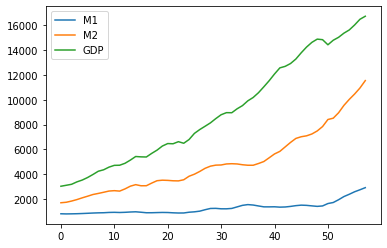

In [124]:
plt.plot(ymoney_df['M1'])
plt.plot(ymoney_df['M2'])
plt.plot(ymoney_df['RGDP'])
plt.legend(['M1', 'M2', 'GDP'])

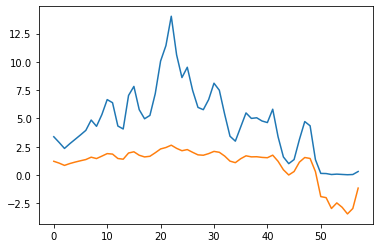

In [125]:
plt.plot(ymoney_df['TB3MS'])
plt.plot(np.log(ymoney_df['TB3MS'])/ np.log(math.e))

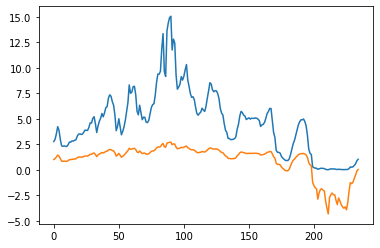

In [126]:
plt.plot(qmoney_df['TB3MS'])
plt.plot(q_X.TB3MS)

In [127]:
# OLS for M1 quarterly 
q_M1_OLS = sm.OLS(q_lnM1, q_X)
q_M1_OLS_results = q_M1_OLS.fit()
print(q_M1_OLS_results.summary())

                            OLS Regression Results                            
Dep. Variable:                     M1   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     943.3
Date:                Thu, 20 Feb 2020   Prob (F-statistic):          3.74e-112
Time:                        22:21:20   Log-Likelihood:                 177.12
No. Observations:                 235   AIC:                            -348.2
Df Residuals:                     232   BIC:                            -337.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0623      0.158     19.333      0.0

In [128]:
sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())


NameError: name 'data' is not defined

In [129]:
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(q_X.RGDP, q_lnM1, 'o', label="data")
# ax.plot(q_X.RGDP, q_M1_OLS_results.fittedvalues, 'o', label="fit")
# ax.legend(loc='best')
# ax.set_title('Quarter M1')
# ax.set_xlabel('ln(RGDP)')
# ax.set_ylabel('ln(M1)')
# fig.savefig("qM1.pdf")

In [130]:
# plt.plot(q_X.RGDP, q_lnM1, 'o', label="data")
# plt.plot(q_X.RGDP, q_M1_OLS_results.fittedvalues, 'g-', label="data")

In [131]:
# OLS for M2 quarterly 
q_M2_OLS = sm.OLS(q_lnM2, q_X)
q_M2_OLS_results = q_M2_OLS.fit()
print(q_M2_OLS_results.summary())

# prstd, iv_l, iv_u = wls_prediction_std(q_M2_OLS_results)
# fig, ax = plt.subplots(figsize=(50,20))

# ax.plot(np.exp(q_lnM2), 'o', label="data")
# ax.plot(np.exp(q_M2_OLS_results.fittedvalues), 'r-', label="data")
# ax.plot(np.exp(iv_u), 'r--', label="confidence")
# ax.plot(np.exp(iv_l), 'r--')
# ax.legend(loc='best')
# ax.set_title('Quarter M2')

                            OLS Regression Results                            
Dep. Variable:                     M2   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     6180.
Date:                Thu, 20 Feb 2020   Prob (F-statistic):          6.06e-202
Time:                        22:21:25   Log-Likelihood:                 295.78
No. Observations:                 235   AIC:                            -585.6
Df Residuals:                     232   BIC:                            -575.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4826      0.096      5.048      0.0

In [132]:
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(q_lnM2, 'o', label="data")
# ax.plot(q_M2_OLS_results.fittedvalues, 'g-', label="fit")
# #ax.plot(q_X.RGDP, q_M1_OLS_results.fittedvalues, 'r-', label="data")
# #ax.plot(q_X.TB3MS, q_lnM1, 'o', label="data")
# ax.legend(loc='best')
# ax.set_title('Quarter M1')
# ax.set_xlabel('ln(RGDP)')
# ax.set_ylabel('ln(M1)')
# fig.savefig("qM1.pdf")

In [133]:
# OLS for M1 yearly
y_M1_OLS = sm.OLS(y_lnM1, y_X)
y_M1_OLS_results = y_M1_OLS.fit()
print(y_M1_OLS_results.summary())

                            OLS Regression Results                            
Dep. Variable:                     M1   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     288.1
Date:                Thu, 20 Feb 2020   Prob (F-statistic):           7.19e-30
Time:                        22:21:37   Log-Likelihood:                 52.860
No. Observations:                  58   AIC:                            -99.72
Df Residuals:                      55   BIC:                            -93.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2579      0.280     11.637      0.0

In [134]:
# fig, ax = plt.subplots(figsize=(20,10))
# ax.plot(y_X.RGDP, y_lnM1, 'o', label="data")
# ax.plot(y_X.RGDP, y_M1_OLS_results.fittedvalues, 'g-', label="fit")
#ax.plot(q_X.RGDP, q_M1_OLS_results.fittedvalues, 'r-', label="data")
#ax.plot(q_X.TB3MS, q_lnM1, 'o', label="data")
# ax.legend(loc='best')
# ax.set_title('Annual M1')
# ax.set_xlabel('ln(RGDP)')
# ax.set_ylabel('ln(M1)')
# fig.savefig("yM1.pdf")

In [135]:
# OLS for M2 yearly
y_M2_OLS = sm.OLS(y_lnM2, y_X)
y_M2_OLS_results = y_M2_OLS.fit()
print(y_M2_OLS_results.summary())
y_M2_OLS_results.params

                            OLS Regression Results                            
Dep. Variable:                     M2   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1813.
Date:                Thu, 20 Feb 2020   Prob (F-statistic):           6.22e-51
Time:                        22:21:49   Log-Likelihood:                 80.201
No. Observations:                  58   AIC:                            -154.4
Df Residuals:                      55   BIC:                            -148.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5867      0.175      3.358      0.0

const    0.586680
TB3MS   -0.053625
RGDP     0.874071
dtype: float64

In [136]:
def gen_sigma(results): 
    from statsmodels.stats.sandwich_covariance import cov_hac as nw_hac
    return nw_hac(results)

In [137]:
#####################################################################################

#################                  Breusch-Godfrey LM Test          #################

#####################################################################################


In [138]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox

acorr_breusch_godfrey(q_M1_OLS_results, nlags=3)

(226.33763801861937,
 8.563100973426011e-49,
 1994.5029318667346,
 8.856900330961851e-164)

In [139]:
acorr_ljungbox(x=q_M1_OLS_results.resid, lags=3, boxpierce=True)

(array([208.31841209, 386.83352194, 537.87473384]),
 array([3.19703575e-047, 1.00038692e-084, 2.95169439e-116]),
 array([205.68147016, 381.18366677, 529.03835521]),
 array([1.20251997e-046, 1.68662474e-083, 2.42819214e-114]))

In [140]:
acorr_breusch_godfrey(q_M2_OLS_results, nlags=3)

(223.10882480885226,
 4.272345187382385e-48,
 1432.2083410579305,
 4.989619746017196e-148)

In [141]:
acorr_ljungbox(x=q_M2_OLS_results.resid, lags=3, boxpierce=True)

(array([209.66919754, 390.70562915, 546.65039301]),
 array([1.62195123e-047, 1.44328004e-085, 3.69796318e-118]),
 array([207.01515706, 384.99612148, 537.65091142]),
 array([6.15312393e-047, 2.50700064e-084, 3.30053063e-116]))

In [142]:
acorr_breusch_godfrey(y_M1_OLS_results, nlags=3)

(48.8607215860768,
 1.3966238789767095e-10,
 92.66805712674487,
 7.327754487836518e-21)

In [143]:
acorr_ljungbox(x=y_M1_OLS_results.resid, lags=3, boxpierce=True)

(array([33.38691438, 48.98468171, 55.06574579]),
 array([7.55304629e-09, 2.30733959e-11, 6.64796135e-12]),
 array([31.71756866, 46.27548483, 51.84979358]),
 array([1.78301936e-08, 8.94141279e-11, 3.22418607e-11]))

In [144]:
acorr_breusch_godfrey(y_M2_OLS_results, nlags=3)

(46.83211576573735,
 3.7734655093284144e-10,
 72.68670199699463,
 1.3173633932040364e-18)

In [145]:
acorr_ljungbox(x=y_M2_OLS_results.resid, lags=3, boxpierce=True)

(array([36.82781996, 59.95404351, 75.82691045]),
 array([1.29035757e-09, 9.57513416e-14, 2.40915959e-16]),
 array([34.98642896, 56.57090428, 71.12103231]),
 array([3.32011289e-09, 5.19737698e-13, 2.45575873e-15]))

In [146]:
#####################################################################################

#################       Robust HAC estimators                       #################

#####################################################################################

In [147]:
np.array(q_M1_OLS_results.cov_params()) # not robust 

array([[ 2.50892935e-02, -5.09742778e-04, -2.72942548e-03],
       [-5.09742778e-04,  3.29078075e-05,  5.31666653e-05],
       [-2.72942548e-03,  5.31666653e-05,  2.97851061e-04]])

In [148]:
np.array(pd.DataFrame(gen_sigma(q_M1_OLS_results))) # Newely west robust 

array([[ 6.75690552e-02, -3.19234805e-04, -7.79122337e-03],
       [-3.19234805e-04,  1.40309232e-04,  1.43427439e-05],
       [-7.79122337e-03,  1.43427439e-05,  9.03257134e-04]])

In [149]:
np.array(q_M2_OLS_results.cov_params())

array([[ 9.13903297e-03, -1.85679045e-04, -9.94221278e-04],
       [-1.85679045e-04,  1.19870070e-05,  1.93665042e-05],
       [-9.94221278e-04,  1.93665042e-05,  1.08495310e-04]])

In [150]:
gen_sigma(q_M2_OLS_results)

array([[ 4.21990914e-02, -6.36317647e-04, -4.72164349e-03],
       [-6.36317647e-04,  3.74228928e-05,  6.75357404e-05],
       [-4.72164349e-03,  6.75357404e-05,  5.29677205e-04]])

In [151]:
np.array(y_M1_OLS_results.cov_params())

array([[ 0.07837872, -0.00163657, -0.00852427],
       [-0.00163657,  0.00010823,  0.00017013],
       [-0.00852427,  0.00017013,  0.00093004]])

In [152]:
gen_sigma(y_M1_OLS_results)

array([[ 7.11107261e-02, -2.95304076e-04, -8.34532977e-03],
       [-2.95304076e-04,  2.99397219e-04, -9.90448013e-06],
       [-8.34532977e-03, -9.90448013e-06,  9.88512607e-04]])

In [153]:
ccc = y_M2_OLS_results.cov_params()

In [154]:
gen_sigma(y_M2_OLS_results)

array([[ 0.09489863, -0.00206931, -0.01045644],
       [-0.00206931,  0.00010472,  0.00022261],
       [-0.01045644,  0.00022261,  0.00115496]])

In [155]:
import sklearn 

In [156]:
mod = sklearn.linear_model.LinearRegression()
mod.fit(y_X, y_lnM1)
mod.score(y_X, y_lnM1)

AttributeError: module 'sklearn' has no attribute 'linear_model'